<h3 style="direction: rtl;">
پروژه که کدهای آن آماده شده است و ما تنها از طریق فایل کانفیگ آن را آموزش می‌دهیم، لود می‌کنیم.
</h3>

In [ ]:
!rm -rf T2F
!git clone https://github.com/YasinEnigma/Text2Image

Cloning into 'Text-to-Face-Composition'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 77 (delta 0), reused 0 (delta 0), pack-reused 74
Unpacking objects: 100% (77/77), done.


<h3 style="direction: rtl;">
کارهای مربوط به لود داده‌ها و دانلود دیتاست‌های لازم
</h3>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mv Text-to-Face-Composition/ T2F/

In [ ]:
!mkdir /content/T2F/implementation/networks/InferSent/models

In [ ]:
!curl -Lo /content/T2F/implementation/networks/InferSent/models/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  55.8M      0  0:00:02  0:00:02 --:--:-- 55.7M


In [ ]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip
!mv /content/gdrive/MyDrive/captions/glove.6B/glove.840B.300d.txt /content/T2F/implementation/networks/InferSent/models/glove.840B.300d.txt

^C


In [ ]:
!cp /content/T2F/implementation/networks/InferSent/models/glove.840B.300d.txt /content/gdrive/My\ Drive/T2F/glove.840B.300d.txt

In [ ]:
!cp -r T2F gdrive/My\ Drive/T2F

^C


In [ ]:
!cp /content/T2F/implementation/networks/InferSent/models/glove.840B.300d.txt /content/gdrive/My\ Drive/T2F/glove.840B.300d.txt

In [ ]:
!cp /content/T2F/implementation/networks/InferSent/models/infersent2.pkl /content/gdrive/My\ Drive/T2F/infersent2.pkl

In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xf lfw.tgz

--2021-01-15 09:46:51--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  36.0MB/s    in 6.4s    

2021-01-15 09:46:57 (26.8 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



<h3 style="direction: rtl;">
    از تنسورفلوی ورژن یک استفاده می‌کنیم.
</h3>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


<h3 style="direction: rtl;">
معرفی بخش‌های لازم که می‌خواهیم با آن‌ها کار کنیم.
</h3>

In [ ]:
import sys
sys.path.append('/content/T2F/implementation')
sys.path.append('/content/T2F/')

In [ ]:
from train_network import main as main_train
from train_network import get_config

import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--config", action="store", type=str, default="/content/T2F/implementation/configs/2_colab.conf",
                    help="default configuration for the Network")
parser.add_argument("--start_depth", action="store", type=int, default=0,
                    help="Starting depth for training the network")
parser.add_argument("--encoder_file", action="store", type=str, default=None,
                    help="pretrained Encoder file (compatible with my code)")
parser.add_argument("--ca_file", action="store", type=str, default=None,
                    help="pretrained Conditioning Augmentor file (compatible with my code)")
parser.add_argument("--generator_file", action="store", type=str, default=None,
                    help="pretrained Generator file (compatible with my code)")
parser.add_argument("--discriminator_file", action="store", type=str, default=None,
                    help="pretrained Discriminator file (compatible with my code)")

args = parser.parse_args([])
config = get_config(args.config)

<h3 style="direction: rtl;">
کلاسی که برای پیاده‌سازی Canditional Augmentation استفاده می‌شود.
</h3>

In [ ]:
import torch as th

class ConditionAugmentor(th.nn.Module):
    """ Perform conditioning augmentation
        from the paper -> https://arxiv.org/abs/1710.10916 (StackGAN++)
        uses the reparameterization trick from VAE paper.
    """

    def __init__(self, input_size, latent_size, use_eql=True, device=th.device("cpu")):
        """
        constructor of the class
        :param input_size: input size to the augmentor
        :param latent_size: required output size
        :param use_eql: boolean for whether to use equalized learning rate
        :param device: device on which to run the Module
        """
        super(ConditionAugmentor, self).__init__()

        assert latent_size % 2 == 0, "Latent manifold has odd number of dimensions"

        # state of the object
        self.device = device
        self.input_size = input_size
        self.latent_size = latent_size

        # required modules:
        if use_eql:
            from pro_gan_pytorch.CustomLayers import _equalized_linear
            self.transformer = _equalized_linear(self.input_size, 2 * self.latent_size).to(device)
        else:
            self.transformer = th.nn.Linear(self.input_size, 2 * self.latent_size).to(device)

    def forward(self, x, epsilon=1e-12):
        """
        forward pass (computations)
        :param x: input
        :param epsilon: a small noise added for numerical stability
        :return: c_not_hat, mus, sigmas => augmented text embeddings, means, stds
        """
        from torch.nn.functional import relu

        # apply the feed forward layer:
        combined = self.transformer(x)

        # use the reparameterization trick
        mid_point = self.latent_size
        mus, sigmas = combined[:, :mid_point], combined[:, mid_point:]

        # mus don't need to be transformed, but sigmas cannot be negative.
        # so, we'll apply a ReLU on top of sigmas
        sigmas = relu(sigmas)  # hopefully the network will learn a good sigma mapping
        sigmas = sigmas + epsilon  # small noise added for stability

        epsilon = th.randn(*mus.shape).to(self.device)
        c_not_hat = (epsilon * sigmas) + mus

        return c_not_hat, mus, sigmas

<h3 style="direction: rtl;">
    در این قسمت‌ پیش  پردازش‌های لازم بروی متن ورودی صورت می‌گیرد. و از یک Embedding  پیش‌آموزش دیده برای Embed کردن متن ورودی استفاده می‌گردد. Embedding پیش‌آموزش دیده در این شبکه glove می‌باشد.
</h3>

In [ ]:
device = 'cuda'

import data_processing.DataLoader as dl

dataset = dl.RawTextFace2TextDataset(
    annots_file=config.annotations_file,
    img_dir=config.images_dir,
    img_transform=dl.get_transform(config.img_dims)
)
from networks.TextEncoder import PretrainedEncoder
# create a new session object for the pretrained encoder:
text_encoder = PretrainedEncoder(
    model_file=config.pretrained_encoder_file,
    embedding_file=config.pretrained_embedding_file,
    device=device
)

Vocab size : 300000


In [ ]:
text_encoder = PretrainedEncoder(
    model_file=config.pretrained_encoder_file,
    embedding_file=config.pretrained_embedding_file,
    device=device
)

Vocab size : 300000


<h3 style="direction: rtl;">
    متن ورودی که به صورت یک بردار Embedding درآمده است به شبکه Conditional Augmentation داده‌ می‌شود. 
</h3>

In [ ]:
condition_augmenter = ConditionAugmentor(
    input_size=config.hidden_size,
    latent_size=config.ca_out_size,
    use_eql=config.use_eql,
    device='cuda'
)

<h3 style="direction: rtl;">
    در این قسمت یک سایز ثابت برای متن ورودی در نظر می‌گیریم و متونی که از ۶۴ بیشتر باشند حذف شده و فقط ۶۴ کلمه اول آن‌ها در نظر گرفته می‌شود.
</h3>

In [ ]:
temp_data = dl.get_data_loader(dataset, 64, num_workers=3)
fixed_captions, fixed_real_images = iter(temp_data).next()
fixed_embeddings = text_encoder(fixed_captions)
fixed_embeddings.shape

/content/T2F/implementation/networks/InferSent/models.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sentences = np.array(sentences)[idx_sort]


(64, 4096)

<h3 style="direction: rtl;">
    آموزش و تغییرات قبلی که بیان شد بروی داده‌ها اعمال و بردار به دست آمده از Conditional Augmentation همراه با بردار نویز ترکیب شده و به شبکه مولد داده‌ می‌شود.
</h3>

In [ ]:
condition_augmenter.train()

# create fixed_input for debugging
temp_data = dl.get_data_loader(dataset, 64, num_workers=3)
fixed_captions, fixed_real_images = iter(temp_data).next()
fixed_embeddings = text_encoder(fixed_captions)
fixed_embeddings = th.from_numpy(fixed_embeddings).to(device)

fixed_c_not_hats, _, _ = condition_augmenter(fixed_embeddings)

fixed_noise = th.randn(len(fixed_captions),
                       config.latent_size - fixed_c_not_hats.shape[-1]).to(device)

fixed_gan_input = th.cat((fixed_c_not_hats, fixed_noise), dim=-1)

/content/T2F/implementation/networks/InferSent/models.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sentences = np.array(sentences)[idx_sort]


In [ ]:
fixed_embeddings.shape

torch.Size([64, 4096])

In [ ]:
import torch
torch.load('/content/T2F/implementation/networks/InferSent/models/infersent2.pkl')

OrderedDict([('enc_lstm.weight_ih_l0',
              tensor([[-0.0188, -0.0096, -0.0165,  ...,  0.0063,  0.0177,  0.0182],
                      [ 0.0040, -0.0170,  0.0282,  ...,  0.0270, -0.0006, -0.0099],
                      [-0.0333,  0.0013,  0.0235,  ...,  0.0239, -0.0444,  0.0009],
                      ...,
                      [ 0.0068, -0.0130, -0.0136,  ..., -0.0003,  0.0145, -0.0031],
                      [-0.0075, -0.0210,  0.0135,  ...,  0.0149, -0.0059,  0.0018],
                      [-0.0076,  0.0241, -0.0258,  ..., -0.0104,  0.0177,  0.0241]])),
             ('enc_lstm.weight_hh_l0',
              tensor([[ 2.4178e-02, -3.4815e-03, -1.5027e-02,  ...,  2.3643e-02,
                       -4.6200e-03, -1.2944e-02],
                      [ 2.1155e-02, -9.4947e-03,  2.8347e-02,  ..., -1.1898e-02,
                       -1.6273e-02, -1.7331e-02],
                      [ 1.6204e-02, -2.0330e-02, -6.8777e-03,  ..., -8.8209e-03,
                       -1.4847e-02, -1.4684e-

In [ ]:
!mkdir /content/gdrive/MyDrive/T2F/training_runs

mkdir: cannot create directory ‘/content/gdrive/MyDrive/T2F/training_runs’: File exists


In [ ]:
!mkdir /content/gdrive/MyDrive/T2F/training_runs/generated_samples /content/gdrive/MyDrive/T2F/training_runs/generated_samples /content/gdrive/MyDrive/T2F/training_runs/generated_samples

mkdir: cannot create directory ‘/content/gdrive/MyDrive/T2F/training_runs/generated_samples’: File exists
mkdir: cannot create directory ‘/content/gdrive/MyDrive/T2F/training_runs/generated_samples’: File exists
mkdir: cannot create directory ‘/content/gdrive/MyDrive/T2F/training_runs/generated_samples’: File exists


In [ ]:
!mkdir /content/gdrive/MyDrive/T2F/training_runs/losses

mkdir: cannot create directory ‘/content/gdrive/MyDrive/T2F/training_runs/losses’: File exists


In [ ]:
!mkdir gdrive/MyDrive/T2F/training_runs/saved_models

In [ ]:
from networks.TextEncoder import PretrainedEncoder
# create a new session object for the pretrained encoder:
text_encoder = PretrainedEncoder(
    model_file='/content/gdrive/My Drive/T2F/implementation/networks/InferSent/models/infersent2.pkl',
    embedding_file='/content/gdrive/My Drive/T2F/implementation/networks/InferSent/models/glove.840B.300d.txt',
    device='cuda'
)

Vocab size : 300000


<h3 style="direction: rtl;">
در این مرحله آموزش شبکه صورت می‌گیرد. 
</h3>

In [ ]:
main_train(args)

/content/T2F/implementation/configs/2_colab.conf
Current Configuration: {'images_dir': '/content/lfw', 'processed_text_file': '/content/T2F/implementation/processed_annotations/processed_text.pkl', 'annotations_file': '/content/T2F/data/face2text_v0.1/clean.json', 'pretrained_encoder_file': '/content/gdrive/My Drive/T2F/infersent2.pkl', 'pretrained_embedding_file': '/content/gdrive/My Drive/T2F/glove.840B.300d.txt', 'log_dir': '/content/gdrive/My Drive/T2F/training_runs/2/losses/', 'sample_dir': '/content/gdrive/My Drive/T2F/training_runs/2/generated_samples/', 'save_dir': '/content/gdrive/My Drive/T2F/training_runs/2/saved_models/', 'captions_length': 100, 'img_dims': [64, 64], 'use_pretrained_encoder': True, 'hidden_size': 4096, 'ca_out_size': 128, 'compressed_latent_size': 32, 'use_eql': True, 'use_ema': True, 'ema_decay': 0.999, 'depth': 5, 'latent_size': 256, 'learning_rate': 0.001, 'beta_1': 0, 'beta_2': 0.99, 'eps': 1e-08, 'drift': 0.001, 'n_critic': 1, 'epochs': [120, 120, 120,

/content/T2F/implementation/networks/InferSent/models.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sentences = np.array(sentences)[idx_sort]




Currently working on Depth:  0
Current resolution: 4 x 4

Epoch: 1
Elapsed [0:00:01.426938]  batch: 1  d_loss: 8.623917  g_loss: 0.077639  kl_los: 1827.769775
Elapsed [0:00:04.818419]  batch: 20  d_loss: 5.096367  g_loss: 1.675290  kl_los: 900.674500
Time taken for epoch: 5.184 secs

Epoch: 2
Elapsed [0:00:06.240680]  batch: 1  d_loss: 4.890356  g_loss: 1.745525  kl_los: 883.663818
Elapsed [0:00:09.347302]  batch: 20  d_loss: -0.352250  g_loss: 5.569273  kl_los: 555.977600
Time taken for epoch: 4.486 secs

Epoch: 3
Elapsed [0:00:10.779512]  batch: 1  d_loss: -0.294394  g_loss: 6.116236  kl_los: 523.319702
Elapsed [0:00:13.815363]  batch: 20  d_loss: -16.396719  g_loss: 20.476305  kl_los: 389.662170
Time taken for epoch: 4.496 secs

Epoch: 4
Elapsed [0:00:15.254456]  batch: 1  d_loss: -16.853781  g_loss: 21.865700  kl_los: 400.391571
Elapsed [0:00:18.320106]  batch: 20  d_loss: -44.492199  g_loss: 51.753059  kl_los: 271.359436
Time taken for epoch: 4.495 secs

Epoch: 5
Elapsed [0:00:1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Elapsed [0:09:23.258823]  batch: 1  d_loss: -243.998138  g_loss: 502.776031  kl_los: 108.777908
Elapsed [0:09:27.261902]  batch: 20  d_loss: -242.401886  g_loss: 497.557312  kl_los: 108.833130
Time taken for epoch: 5.800 secs

Epoch: 2
Elapsed [0:09:28.878442]  batch: 1  d_loss: -242.246704  g_loss: 497.176849  kl_los: 108.827965
Elapsed [0:09:32.550462]  batch: 20  d_loss: -245.193451  g_loss: 499.704529  kl_los: 108.947464
Time taken for epoch: 5.277 secs

Epoch: 3
Elapsed [0:09:34.060024]  batch: 1  d_loss: -245.014481  g_loss: 499.859589  kl_los: 108.944687
Elapsed [0:09:37.724654]  batch: 20  d_loss: -242.492859  g_loss: 493.997833  kl_los: 108.998657
Time taken for epoch: 5.075 secs

Epoch: 4
Elapsed [0:09:39.247924]  batch: 1  d_loss: -243.950989  g_loss: 497.360596  kl_los: 109.042336
Elapsed [0:09:42.817692]  batch: 20  d_loss: -244.827438  g_loss: 500.515961  kl_los: 109.112343
Time taken for epoch: 5.172 secs

Epoch: 5
Elapsed [0:09:44.411489]  batch: 1  d_loss: -244.832092 

<h3 style="direction: rtl;">
تغییرات مربوط به توابع خطا را نمایش می‌دهد. در این شبکه سه تابع خطا داریم. یک تابع خطا برای شبکه generator، یک تابع خطای برای شبکه Discriminator و یک تابع خطا که میزان مشابهت بین توزیع بردار Embedding متن و توزیع نرمال را اندازه‌گیری می‌:ند که به آن KL Divergence می‌گویند.
</h3>

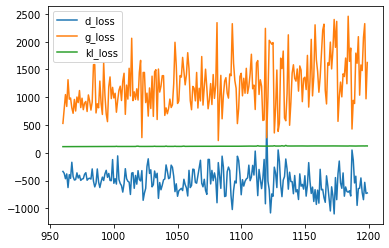

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(4, 5):
  log = pd.read_csv('/content/gdrive/My Drive/T2F/training_runs/2/losses/loss_{}.log'.format(i), delimiter='\t', header=None, names=['d_loss', 'g_loss', 'kl_loss'])
  n = len(log.d_loss)
  xs = list(range(n*i, n*(i + 1)))
  plt.plot(xs, log.d_loss)
  plt.plot(xs, log.g_loss)
  plt.plot(xs, log.kl_loss)
  plt.legend(log.columns)

<h3 style="direction: rtl;">
    از شبکه آموزش دیده شده برای تولید تصویر از متن استفاده می‌کنیم. 
</h3>

In [ ]:
from networks.ConditionAugmentation import ConditionAugmentor
from pro_gan_pytorch.PRO_GAN import ConditionalProGAN

import numpy as np

def create_grid(samples, scale_factor, img_file, real_imgs=False):
    """
    utility function to create a grid of GAN samples
    :param samples: generated samples for storing
    :param scale_factor: factor for upscaling the image
    :param img_file: name of file to write
    :param real_imgs: turn off the scaling of images
    :return: None (saves a file)
    """
    from torchvision.utils import save_image
    from torch.nn.functional import interpolate

    samples = th.clamp((samples / 2) + 0.5, min=0, max=1)

    # upsample the image
    if not real_imgs and scale_factor > 1:
        samples = interpolate(samples,
                              scale_factor=scale_factor)

    # save the images:
    save_image(samples, img_file, nrow=int(np.sqrt(len(samples))))

In [ ]:
# create the networks

condition_augmenter = ConditionAugmentor(
    input_size=config.hidden_size,
    latent_size=config.ca_out_size,
    use_eql=config.use_eql,
    device=device
)

ca_file = '/content/gdrive/My Drive/T2F/training_runs/2/saved_models/Condition_Augmentor_4.pth'

print("Loading conditioning augmenter from:", ca_file)
condition_augmenter.load_state_dict(th.load(ca_file))

c_pro_gan = ConditionalProGAN(
    embedding_size=config.hidden_size,
    depth=config.depth,
    latent_size=config.latent_size,
    compressed_latent_size=config.compressed_latent_size,
    learning_rate=config.learning_rate,
    beta_1=config.beta_1,
    beta_2=config.beta_2,
    eps=config.eps,
    drift=config.drift,
    n_critic=config.n_critic,
    use_eql=config.use_eql,
    loss=config.loss_function,
    use_ema=config.use_ema,
    ema_decay=config.ema_decay,
    device=device
)

generator_file = '/content/gdrive/My Drive/T2F/training_runs/2/saved_models/GAN_GEN_4.pth'
print("Loading generator from:", generator_file)
c_pro_gan.gen.load_state_dict(th.load(generator_file))

Loading conditioning augmenter from: /content/gdrive/My Drive/T2F/training_runs/2/saved_models/Condition_Augmentor_4.pth
Loading generator from: /content/gdrive/My Drive/T2F/training_runs/2/saved_models/GAN_GEN_4.pth


<All keys matched successfully>

In [ ]:
condition_augmenter.train(False)

ConditionAugmentor(
  (transformer): _equalized_linear()
)

In [ ]:
temp_data = dl.get_data_loader(dataset, 1, num_workers=3)
fixed_captions, fixed_real_images = iter(temp_data).next()

In [ ]:
str = input('Enter your caption : ')

Enter your caption : a young woman with blond hair and big nose 


In [ ]:
fixed_caption = (str,)
fixed_captions = fixed_caption

In [ ]:
fixed_embeddings = text_encoder(fixed_captions)
fixed_embeddings = th.from_numpy(fixed_embeddings).to(device)

fixed_c_not_hats, mus, _ = condition_augmenter(fixed_embeddings)

fixed_noise = th.zeros(len(fixed_captions),
                       c_pro_gan.latent_size - fixed_c_not_hats.shape[-1]).to(device)

fixed_gan_input = th.cat((fixed_c_not_hats, fixed_noise), dim=-1)

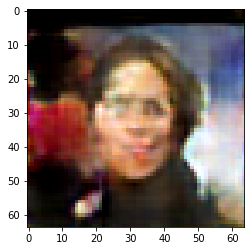

In [ ]:
create_grid(
    samples=c_pro_gan.gen(
        fixed_gan_input,
        4,
        1.0
    ),
    scale_factor=1,
    img_file='output.png')

img = plt.imread('output.png')
plt.figure()
plt.imshow(img)

In [ ]:
  fixed_captions

('a young and attractive woman',)